# Install and import necessary libraries

In [ ]:
!pip install -q -U tensorflow tensorflow-datasets gradio



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.8 MB/s eta 0:0

In [ ]:
import numpy as np
import gradio as gr
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

# Load and preprocess the dataset

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names

228813984/228813984 [==============================] - 1s 0us/step
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


# dataset visualization

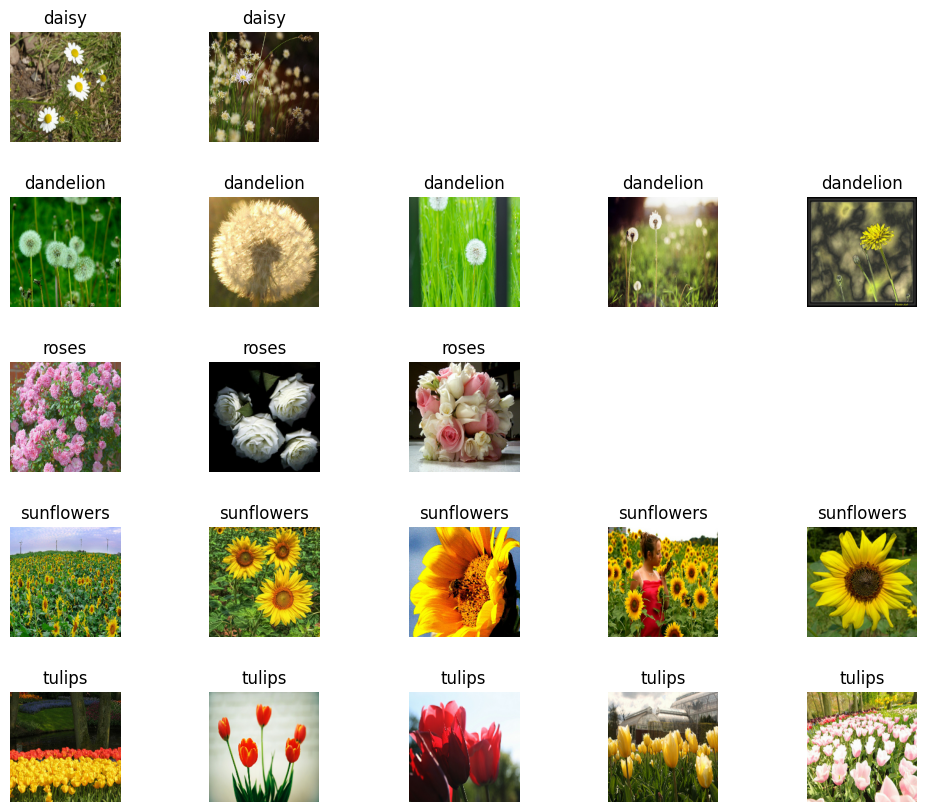

In [ ]:
import matplotlib.pyplot as plt

# Function to plot sample images from the dataset
def plot_sample_images(dataset, class_names, num_images=5):
    plt.figure(figsize=(12, 10))
    for images, labels in dataset.take(1):  # Take one batch of data (you can increase this number if needed)
        for class_idx, class_name in enumerate(class_names):
            class_images = images[labels == class_idx]
            for i in range(min(num_images, len(class_images))):
                plt.subplot(len(class_names), num_images, class_idx * num_images + i + 1)
                plt.imshow(class_images[i].numpy().astype("uint8"))
                plt.title(class_name)
                plt.axis("off")
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

# Call the function to plot sample images from the dataset
plot_sample_images(train_ds, class_names)


# Create and train pipelines for different models

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation="softmax")
])
model.compile(
  optimizer='adam',
  loss='SparseCategoricalCrossentropy',
  metrics=['accuracy'])

# Train the model and store the history
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=4
)


Epoch 1/4
92/92 [==============================] - 7s 46ms/step - loss: 1.5958 - accuracy: 0.3382 - val_loss: 1.3458 - val_accuracy: 0.4877
Epoch 2/4
92/92 [==============================] - 4s 44ms/step - loss: 1.1407 - accuracy: 0.5143 - val_loss: 1.2700 - val_accuracy: 0.4768
Epoch 3/4
92/92 [==============================] - 4s 44ms/step - loss: 1.0553 - accuracy: 0.5722 - val_loss: 1.2090 - val_accuracy: 0.5054
Epoch 4/4
92/92 [==============================] - 4s 43ms/step - loss: 0.9788 - accuracy: 0.6069 - val_loss: 1.1173 - val_accuracy: 0.5450


# Visualize the results

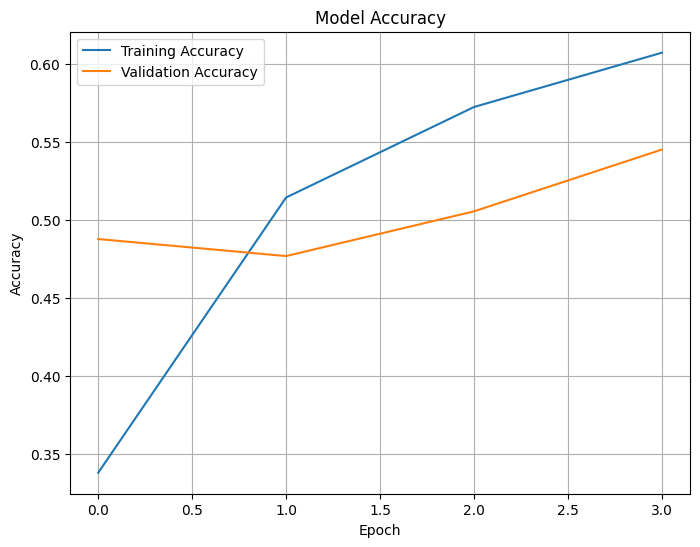

In [ ]:
# Plot the accuracy graph
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# prediction

In [ ]:
import gradio as gr
import numpy as np
import tensorflow as tf
import requests
from PIL import Image
from io import BytesIO

# Function to load and preprocess the image from the provided URL
def load_image_from_url(url, img_height, img_width):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((img_height, img_width))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img /= 255.0  # Normalize the image
    return img

# Function to make predictions on the input image
def predict_input_image(img_url):
    test_image = load_image_from_url(img_url, img_height, img_width)
    img_4d = test_image.reshape(-1, img_height, img_width, 3)
    prediction = model.predict(img_4d)[0]
    return {class_names[i]: float(prediction[i] * 0.100) for i in range(5)}

# Load a random test image from the test directory
img_height = 180
img_width = 180

# Define Gradio Interface Components
image_url = gr.inputs.Textbox(label="Enter Image URL:")
image = gr.Interface(fn=predict_input_image, inputs=image_url, outputs=gr.outputs.Label(num_top_classes=5))

# Launch the Gradio Interface
image.launch()


<ipython-input-15-7702173cc01c>:29: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image_url = gr.inputs.Textbox(label="Enter Image URL:")
<ipython-input-15-7702173cc01c>:29: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image_url = gr.inputs.Textbox(label="Enter Image URL:")
<ipython-input-15-7702173cc01c>:29: GradioDeprecationWarning: `numeric` parameter is deprecated, and it has no effect
  image_url = gr.inputs.Textbox(label="Enter Image URL:")
<ipython-input-15-7702173cc01c>:30: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  image = gr.Interface(fn=predict_input_image, inputs=image_url, outputs=gr.outputs.Label(num_top_classes=5))
<ipython-input-15-7702173cc01c>:30: GradioUnusedKwargWarning: You have unused kwarg paramet

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>